In [1]:
from math import sqrt

import numpy as np
import seaborn as sns

sns.set_style('whitegrid')

In [2]:
def generate_rnorms(N, Ws, params_list):
    rnorms = [np.random.normal(params[0], params[1], round(N*w)) for params, w in zip(params_list, Ws)]
    mix = np.concatenate(rnorms)
    mix_strs = [f'{w}×N({params[0]}, {params[1]})' for params, w in zip(params_list, Ws)]
    print (' + '.join(mix_strs))
    print(f'Population mean: {np.mean(mix)}')
    print(f'Population variance: {np.var(mix)}')
    _ = sns.kdeplot(mix, bw=0.5)
    return rnorms

In [3]:
def print_modelling_and_estimation_results(choice, iters, n, rnorms, Ws, params_list):
    print(f'Choice: {choice}')
    if choice.startswith('stratify'):
        strat_sample_sizes = get_strat_sample_sizes(n, Ws, params_list, strategy=choice.rsplit('_', 1)[1])
        n = strat_sample_sizes
        print(f'Strat samples sizes: {n}')
    
    print('Modelling results')
    modelling_stats = model_point_estimates(choice, iters, n, rnorms)
    print_stats(modelling_stats)
    
    if choice.startswith('stratify'):
        print('Estimation results')
        estimation_stats = estimate_point_estimates(rnorms, strat_sample_sizes, Ws)
        print_stats(estimation_stats)

def print_stats(stats):
    print(f'\tMean mean: {stats[0]}')
    print(f'\tMean variance: {stats[1]}')
    print(f'\tVariance mean: {stats[2]}')
    print(f'\tVariance variance: {stats[3]}')

In [4]:
def get_strat_sample_sizes(n, Ws, params_list, strategy):
    if strategy == 'prop':
        nks = [int(n * w) for w in Ws]
    elif strategy == 'optimal':
        np_Ws = np.array(Ws)
        np_sigmas = np.array([sqrt(sigma_square) for _, sigma_square in params_list])
        props = np.divide(np.multiply(np_Ws, np_sigmas), np.dot(np_Ws, np_sigmas))
        nks = [int(round(n * prop)) for prop in props]
    return nks

In [5]:
def model_point_estimates(choice, iters, n, rnorms):
    """Models point estimates by repeated sampling.
    
    If `choice` is stratification based `n` is expected to be list of strat sample sizes. 
    """
    means = []
    variances = []
    for i in range(iters):    
        if choice == 'simple':
            mix = np.concatenate(rnorms)
            sample = np.random.choice(mix, n)
            means.append(np.mean(sample))
            variances.append(np.var(sample))
        elif choice.startswith('stratify'):
            strat_samples = [np.random.choice(rnorm, nk) for rnorm, nk in zip(rnorms, n)]
            strat_mix = np.concatenate(strat_samples)
            means.append(np.mean(strat_mix))
            variances.append(np.var(strat_mix))
    return np.mean(means), np.var(means), np.mean(variances), np.var(variances)

In [6]:
def estimate_point_estimates(rnorms, strat_sample_sizes, Ws):
    strat_samples = [np.random.choice(rnorm, nk) for rnorm, nk in zip(rnorms, strat_sample_sizes)]
    strat_means = np.array([np.mean(sample) for sample in strat_samples])
    strat_vars = np.array([np.var(sample) for sample in strat_samples])
    w = np.array(Ws)
    strats_number = len(strat_sample_sizes)
    
    mean_mean = np.dot(w, np.full(strats_number, np.mean(strat_means)))
    mean_var = np.dot(np.square(w), np.full(strats_number, np.var(strat_means)))
    w_dot_mean_minus_mean = np.subtract(np.dot(w, strat_means), strat_means)
    var_mean = np.add(np.dot(w, np.full(strats_number, np.mean(strat_vars))), np.dot(w, np.full(strats_number, np.square(np.mean(w_dot_mean_minus_mean)))))
    var_var = np.add(np.dot(np.square(w), np.full(strats_number, np.var(strat_vars))), np.var(np.dot(w, np.square(w_dot_mean_minus_mean))))
    
    return mean_mean, mean_var, var_mean, var_var

In [7]:
_iters = 1000
_N = 500
_n = 40
_Ws = [0.3, 0.5, 0.2]

### Same means and vars

0.3×N(3, 1) + 0.5×N(3, 1) + 0.2×N(3, 1)
Population mean: 2.958387880754215
Population variance: 1.0105541916841336


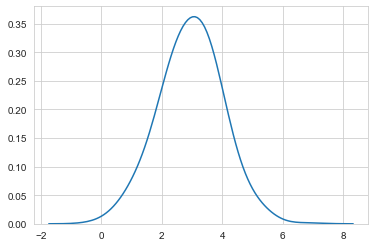

In [8]:
_params_list = [(3, 1), (3, 1), (3, 1)]
_rnorms = generate_rnorms(_N, _Ws, _params_list)

##### Simple random choice

In [9]:
print_modelling_and_estimation_results('simple', _iters, _n, _rnorms, _Ws, _params_list)

Choice: simple
Modelling results
	Mean mean: 2.9613820643416533
	Mean variance: 0.024626471704460185
	Variance mean: 0.9842507416337312
	Variance variance: 0.05475573608671973


##### Stratified proportionally

In [10]:
print_modelling_and_estimation_results('stratify_prop', _iters, _n, _rnorms, _Ws, _params_list)

Choice: stratify_prop
Strat samples sizes: [12, 20, 8]
Modelling results
	Mean mean: 2.9504713863019605
	Mean variance: 0.026541022712204557
	Variance mean: 0.9827951542563723
	Variance variance: 0.054359721503052114
Estimation results
	Mean mean: 2.879894950827696
	Mean variance: 0.05169283205106852
	Variance mean: 0.6601858828935958
	Variance variance: 0.008938140438434022


##### Stratified optimally

In [11]:
print_modelling_and_estimation_results('stratify_optimal', _iters, _n, _rnorms, _Ws, _params_list)

Choice: stratify_optimal
Strat samples sizes: [12, 20, 8]
Modelling results
	Mean mean: 2.9552526879664227
	Mean variance: 0.02590031404684976
	Variance mean: 0.9926414918539672
	Variance variance: 0.0636320866080864
Estimation results
	Mean mean: 2.8622551774299523
	Mean variance: 0.0036785672709565786
	Variance mean: 0.8803718804027325
	Variance variance: 0.06346397003102404


### Different means same vars

0.3×N(0, 1) + 0.5×N(10, 1) + 0.2×N(3, 1)
Population mean: 5.536510191031865
Population variance: 22.288264007017307


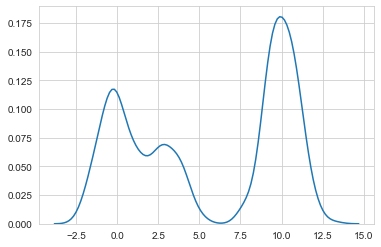

In [12]:
_params_list = [(0, 1), (10, 1), (3, 1)]
_rnorms = generate_rnorms(_N, _Ws, _params_list)

##### Simple random choice

In [13]:
print_modelling_and_estimation_results('simple', _iters, _n, _rnorms, _Ws, _params_list)

Choice: simple
Modelling results
	Mean mean: 5.510043017336902
	Mean variance: 0.5695630109978718
	Variance mean: 21.642437901513365
	Variance variance: 4.314827881096413


##### Stratified proportionally

In [14]:
print_modelling_and_estimation_results('stratify_prop', _iters, _n, _rnorms, _Ws, _params_list)

Choice: stratify_prop
Strat samples sizes: [12, 20, 8]
Modelling results
	Mean mean: 5.538557927877181
	Mean variance: 0.02071495842561454
	Variance mean: 22.2532315435177
	Variance variance: 1.9913586607201605
Estimation results
	Mean mean: 4.2533483777897665
	Mean variance: 7.78036975497361
	Variance mean: 2.4366070457275684
	Variance variance: 0.0024435449902620067


##### Stratified optimally

In [15]:
print_modelling_and_estimation_results('stratify_optimal', _iters, _n, _rnorms, _Ws, _params_list)

Choice: stratify_optimal
Strat samples sizes: [12, 20, 8]
Modelling results
	Mean mean: 5.537248830099438
	Mean variance: 0.02184669996525459
	Variance mean: 22.260227880112144
	Variance variance: 1.9214463928577943
Estimation results
	Mean mean: 4.113428377503908
	Mean variance: 7.375700046747949
	Variance mean: 2.4823547112475612
	Variance variance: 0.030798490335145028


### Different means and vars

0.3×N(0, 0.5) + 0.5×N(10, 1) + 0.2×N(3, 0.1)
Population mean: 5.570714491971751
Population variance: 20.984143213551075


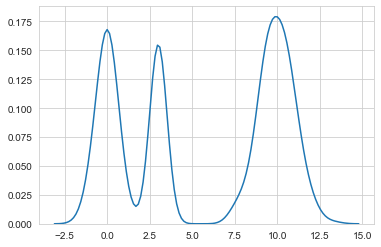

In [16]:
_params_list = [(0, .5), (10, 1), (3, .1)]
_rnorms = generate_rnorms(_N, _Ws, _params_list)

##### Simple random choice

In [17]:
print_modelling_and_estimation_results('simple', _iters, _n, _rnorms, _Ws, _params_list)

Choice: simple
Modelling results
	Mean mean: 5.565275609074417
	Mean variance: 0.5259001789532347
	Variance mean: 20.511215853654672
	Variance variance: 3.6970006059781304


##### Stratified proportionally

In [18]:
print_modelling_and_estimation_results('stratify_prop', _iters, _n, _rnorms, _Ws, _params_list)

Choice: stratify_prop
Strat samples sizes: [12, 20, 8]
Modelling results
	Mean mean: 5.564662148524614
	Mean variance: 0.015050986377702181
	Variance mean: 20.89985505309516
	Variance variance: 1.3443234703288958
Estimation results
	Mean mean: 4.207904150455545
	Mean variance: 5.900477133634235
	Variance mean: 1.8281636290572243
	Variance variance: 0.07104891180348238


##### Stratified optimally

In [19]:
print_modelling_and_estimation_results('stratify_optimal', _iters, _n, _rnorms, _Ws, _params_list)

Choice: stratify_optimal
Strat samples sizes: [11, 26, 3]
Modelling results
	Mean mean: 6.690109227626129
	Mean variance: 0.017540278736590118
	Variance mean: 21.11725759778727
	Variance variance: 1.0557905495564668
Estimation results
	Mean mean: 4.4801444919335855
	Mean variance: 6.6916221930700175
	Variance mean: 2.1843403062820332
	Variance variance: 0.17932785315644278
